# Time Series Forecasting using XGBoost - Usaquén


In [240]:
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree
#from german_holidays import get_german_holiday_calendar
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10') # for graph stying


# Preparing the data

In this step, let's prepare our dataset to get daily Traffic incidents, and some extra features like daily, weekly and week day values. We will use the data from 2016, the date from which ¨Vision Cero¨ began to be implemented.

In [347]:
df = pd.read_csv('siniestros_con_hipotesis.csv')

In [348]:
df['LOCALIDAD'].unique()

array(['Engativá', 'Suba', 'Ciudad Bolívar', 'Chapinero', 'Kennedy',
       'San Cristóbal', 'Fontibón', 'Puente Aranda', 'Bosa', 'Usme',
       'Los Mártires', 'Usaquén', 'Teusaquillo', 'Barrios Unidos',
       'Tunjuelito', 'La Candelaria', 'Santa Fe', 'Rafael Uribe Uribe',
       'Antonio Nariño', 'Sumapaz'], dtype=object)

In [349]:
df = df[(df['ANO']>=2016)  & (df['LOCALIDAD']=='Usaquén')]

In [350]:
siniestros = pd.DataFrame(df.groupby('FECHA')['CODIGO_SINIESTRO'].count().reset_index(name='Cantidad_siniestros'))
siniestros['FECHA'] = pd.to_datetime(siniestros['FECHA'])
siniestros = siniestros.sort_values(by=['FECHA'])
siniestros.set_index('FECHA', inplace=True)
siniestros.head()

,Cantidad_siniestros
FECHA,
2016-01-01,2
2016-01-02,13
2016-01-03,14
2016-01-04,12
2016-01-05,3


In [351]:
main_df = siniestros.copy()

In [352]:
main_df.index.rename('From', inplace=True)

In [353]:
main_df

,Cantidad_siniestros
From,
2016-01-01,2
2016-01-02,13
2016-01-03,14
2016-01-04,12
2016-01-05,3
...,...
2019-12-27,9
2019-12-28,2
2019-12-29,3


In [354]:
main_df.describe()

,Cantidad_siniestros
count,1459.000000
mean,10.013708
std,4.250694
min,1.000000
25%,7.000000
50%,10.000000
75%,13.000000
max,28.000000


In [355]:
main_df.isnull().sum()

Cantidad_siniestros    0
dtype: int64

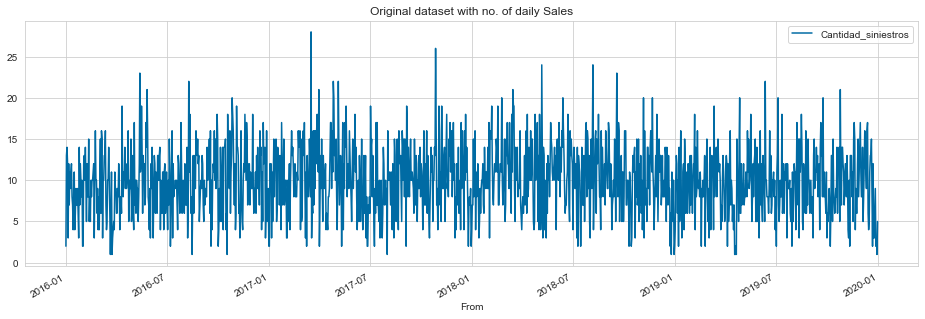

In [356]:
main_df.plot(figsize=(16,5))
plt.title('Original dataset with no. of daily Sales')
plt.show()

As we can see above, the dataset gets more stable from 2016 to now. We should be aware of this before setting the cut-line for the training dataset

In [357]:
training_df = main_df.groupby(['From'])['Cantidad_siniestros'].sum().reset_index()
training_df['Date'] = pd.to_datetime(training_df['From']).dt.date

training_df['From'] = pd.to_datetime(training_df['From'])

In [358]:
training_df.set_index('From', inplace=True)
training_df = training_df['2015-01-01':]
training_df.head()

,Cantidad_siniestros,Date
From,,
2016-01-01,2,2016-01-01
2016-01-02,13,2016-01-02
2016-01-03,14,2016-01-03
2016-01-04,12,2016-01-04
2016-01-05,3,2016-01-05


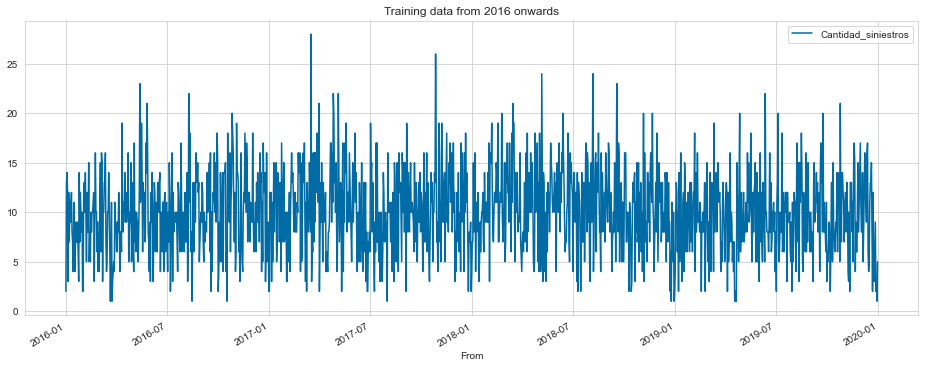

In [359]:
training_df.plot(figsize=(16,6))
plt.title('Training data from 2016 onwards')
plt.show()

Voilà, now the training data seems to be predictible.

In [360]:
training_df.describe()

,Cantidad_siniestros
count,1459.000000
mean,10.013708
std,4.250694
min,1.000000
25%,7.000000
50%,10.000000
75%,13.000000
max,28.000000


In [361]:
# Extracting More info, setting features for the XGBoost
training_df['Year'] = pd.to_datetime(training_df['Date']).dt.year
training_df['Week'] = pd.to_datetime(training_df['Date']).dt.week
training_df['Day'] = pd.to_datetime(training_df['Date']).dt.day
training_df['WeekDay'] = pd.to_datetime(training_df['Date']).dt.dayofweek
training_df['Weekend'] = training_df.WeekDay.isin([5, 6]).astype(int)
training_df.head()

,Cantidad_siniestros,Date,Year,Week,Day,WeekDay,Weekend
From,,,,,,,
2016-01-01,2,2016-01-01,2016,53,1,4,0
2016-01-02,13,2016-01-02,2016,53,2,5,1
2016-01-03,14,2016-01-03,2016,53,3,6,1
2016-01-04,12,2016-01-04,2016,1,4,0,0
2016-01-05,3,2016-01-05,2016,1,5,1,0


In [362]:
training_df.corr()

,Cantidad_siniestros,Year,Week,Day,WeekDay,Weekend
Cantidad_siniestros,1.000000,-0.007782,0.020366,0.037979,-0.088197,-0.157948
Year,-0.007782,1.000000,-0.006559,-0.001705,-0.001989,-0.001352
Week,0.020366,-0.006559,1.000000,0.067796,0.007880,0.004571
Day,0.037979,-0.001705,0.067796,1.000000,-0.003705,-0.001619
WeekDay,-0.088197,-0.001989,0.007880,-0.003705,1.000000,0.791097
Weekend,-0.157948,-0.001352,0.004571,-0.001619,0.791097,1.000000


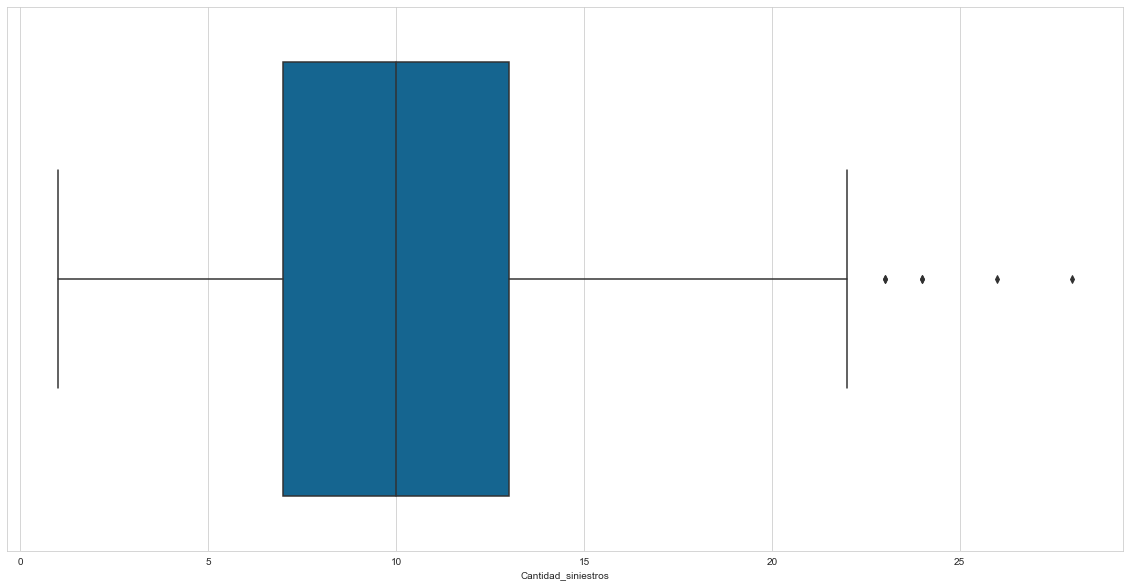

In [363]:
sns.boxplot(x=training_df['Cantidad_siniestros'])
plt.show()

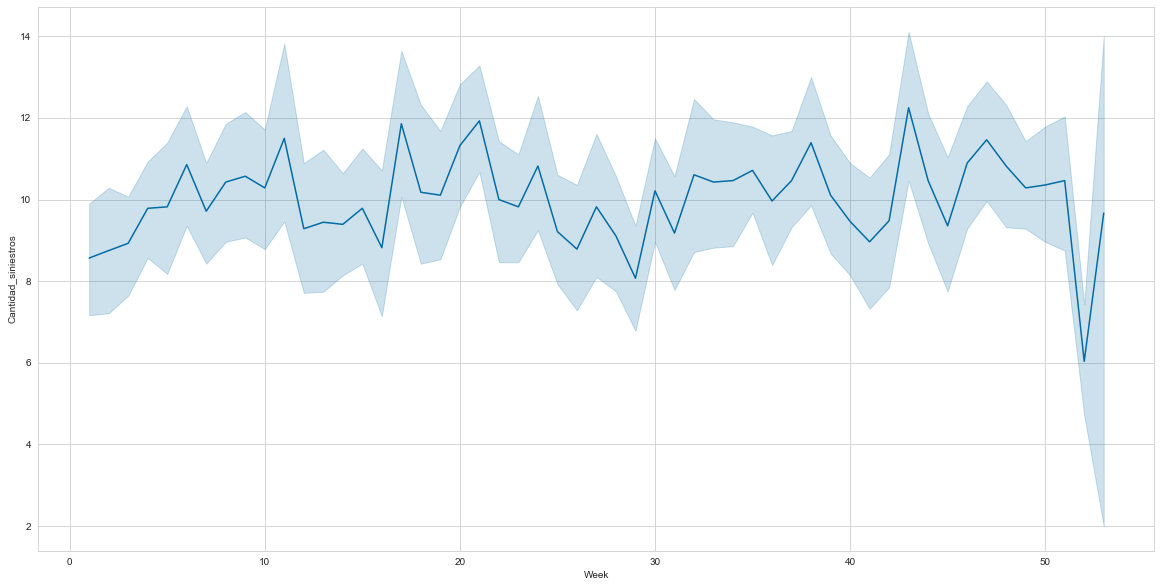

In [364]:
sns.lineplot(training_df['Week'], training_df['Cantidad_siniestros'])
plt.show()

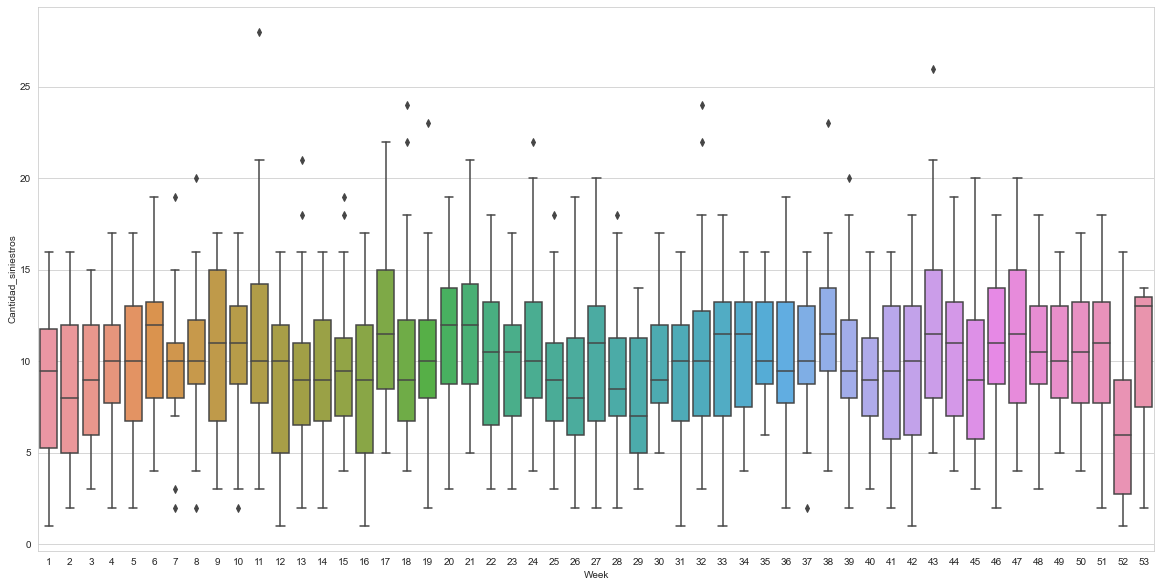

In [365]:
sns.boxplot(training_df['Week'], training_df['Cantidad_siniestros'])
plt.show()

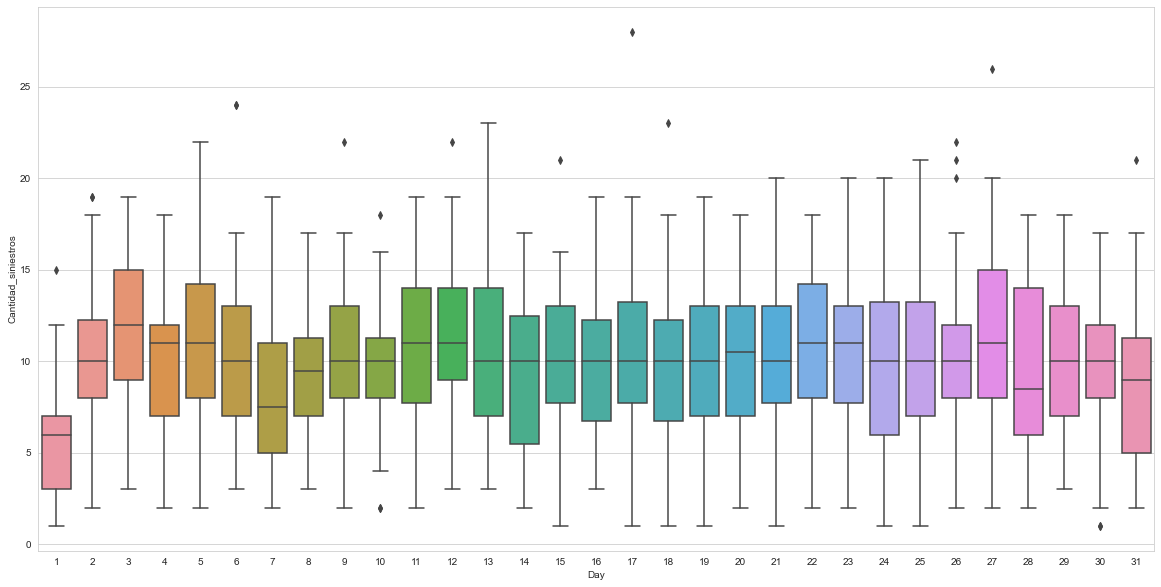

In [366]:
sns.boxplot(training_df['Day'], training_df['Cantidad_siniestros'])
plt.show()

In [367]:
training_df.drop(['Date'], axis=1, inplace=True)
print(training_df.dtypes)
print(training_df.size)
training_df.head()

Cantidad_siniestros    int64
Year                   int64
Week                   int64
Day                    int64
WeekDay                int64
Weekend                int32
dtype: object
8754


,Cantidad_siniestros,Year,Week,Day,WeekDay,Weekend
From,,,,,,
2016-01-01,2,2016,53,1,4,0
2016-01-02,13,2016,53,2,5,1
2016-01-03,14,2016,53,3,6,1
2016-01-04,12,2016,1,4,0,0
2016-01-05,3,2016,1,5,1,0


# Train/Test Split

Cut off the data after 1st Jan 2019 to use as our validation set.

In [368]:
split_date = '2019-12-01'
df_train = training_df.loc[training_df.index <= split_date].copy()
df_test = training_df.loc[training_df.index > split_date].copy()

# Create Time Series Features

Extract various time series features

In [369]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df[[
        'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
        'dayofmonth', 'weekofyear'
    ]]
    if label:
        y = df[label]
        return X, y
    return X

In [370]:
X_train, y_train = create_features(df_train, label='Cantidad_siniestros')
X_test, y_test = create_features(df_test, label='Cantidad_siniestros')

# Create XGBoost Model

## Tunning the hyper parameters with grid search

In [371]:
# A parameter grid for XGBoost
params = {
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}

# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')

grid = GridSearchCV(xgb_reg, params)
grid.fit(X_train, y_train)

gridcv_xgb = grid.best_estimator_
print(r2_score(y_test, gridcv_xgb.predict(X_test)))

0.3356067157234284


R²-score = 0.25 from 2018  R²-score = 0.358 from 2017  R²-score = 0.335 from 2017 

## Feature Importances

This is a metric that simply sums up how many times each feature is split on.

We can see that the dayofyear of year was most commonly used to split trees, while dayofmonth and weekofyear came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

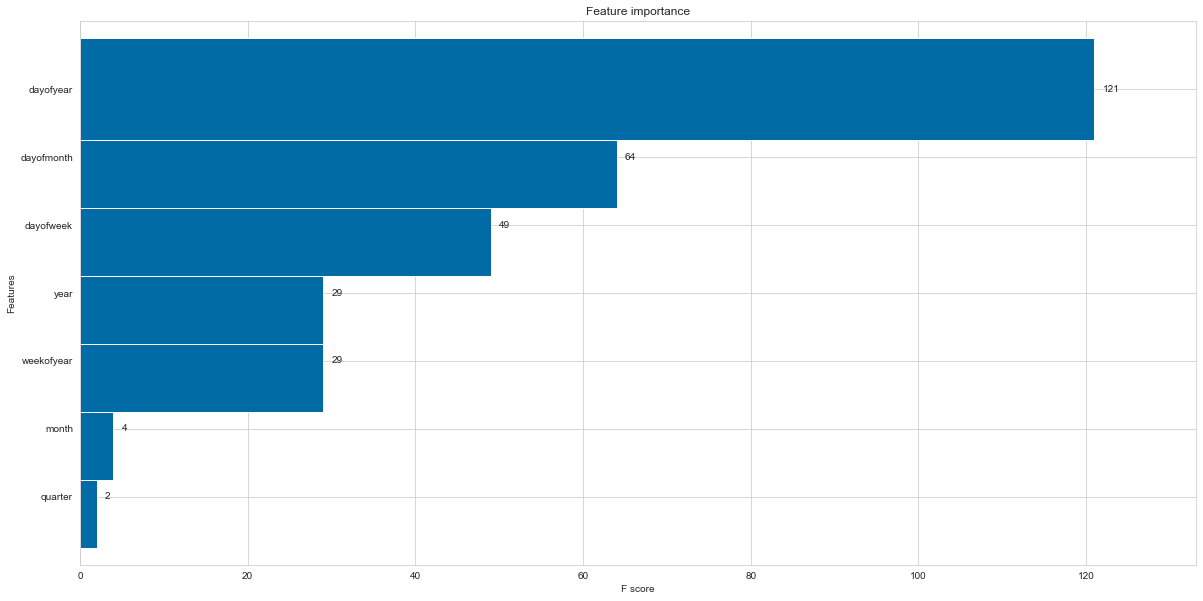

In [372]:
_ = plot_importance(gridcv_xgb, height=1.5)

# Forecast on Test Set

In [373]:
df_test['Prediction'] = gridcv_xgb.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

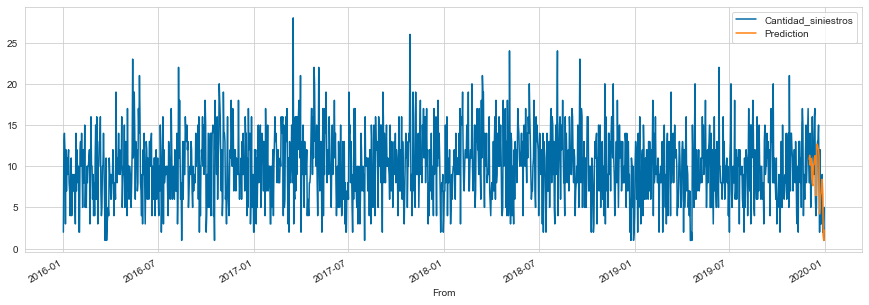

In [374]:
_ = df_all[['Cantidad_siniestros','Prediction']].plot(figsize=(15, 5))

# Look at first month of predictions

In [375]:
df_all.head().T

From,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06
Cantidad_siniestros,8,8,14,5,8
Year,2019,2019,2019,2019,2019
Week,49,49,49,49,49
Day,2,3,4,5,6
WeekDay,0,1,2,3,4
Weekend,0,0,0,0,0
date,2019-12-02 00:00:00,2019-12-03 00:00:00,2019-12-04 00:00:00,2019-12-05 00:00:00,2019-12-06 00:00:00
hour,0,0,0,0,0
dayofweek,0,1,2,3,4
quarter,4,4,4,4,4


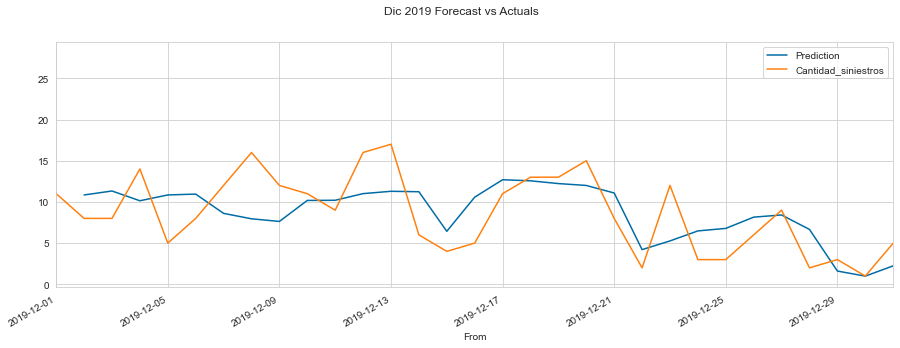

In [376]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['Prediction','Cantidad_siniestros']].plot(ax=ax, style=['-','-'])
ax.set_xbound(lower='2019-12-01', upper='2019-12-31')
plot = plt.suptitle('Dic 2019 Forecast vs Actuals')

In [377]:
mean_squared_error(y_true=df_test['Cantidad_siniestros'],
                   y_pred=df_test['Prediction'])

14.381161745546544

In [378]:
mean_absolute_error(y_true=df_test['Cantidad_siniestros'],
                   y_pred=df_test['Prediction'])

3.2451214134693145

In [379]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [380]:
mean_absolute_percentage_error(y_true=df_test['Cantidad_siniestros'],
                   y_pred=df_test['Prediction'])

52.93989440803644

MAPE = 13.8292

# Look at Worst and Best Predicted Days

In [381]:
df_test['error'] = df_test['Cantidad_siniestros'] - df_test['Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year', 'month', 'dayofmonth']) \
    .mean()[['Cantidad_siniestros', 'Prediction', 'error', 'abs_error']]

In [382]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head()

Cantidad_siniestros  Prediction     error  abs_error
year month dayofmonth                                                      
2019 12    5                             5   10.845748 -5.845748   5.845748
           16                            5   10.578644 -5.578644   5.578644
           14                            6   11.236053 -5.236053   5.236053
           28                            2    6.659996 -4.659996   4.659996
           25                            3    6.786823 -3.786823   3.786823

In [383]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head()

Cantidad_siniestros  Prediction     error  abs_error
year month dayofmonth                                                      
2019 12    30                            1    0.995302  0.004698   0.004698
           18                           13   12.561028  0.438972   0.438972
           27                            9    8.416654  0.583346   0.583346
           19                           13   12.225770  0.774230   0.774230
           10                           11   10.179744  0.820256   0.820256

# Forecasting

In [384]:
test = pd.read_excel('predictionempty2.xlsx', parse_dates=[0], index_col=[0])
pred_x, pred_y = create_features(test, label='Sales')

test['xgb_Prediction'] = gridcv_xgb.predict(pred_x)

test.drop(['Sales','hour','dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'date'], axis=1, inplace=True)
test.head(100)

,xgb_Prediction
Date,
2020-01-01,3.083091
2020-01-02,8.697541
2020-01-03,11.106984
2020-01-04,8.959176
2020-01-05,8.547343
...,...
2020-04-05,9.901207
2020-04-06,8.565953
2020-04-07,8.307559


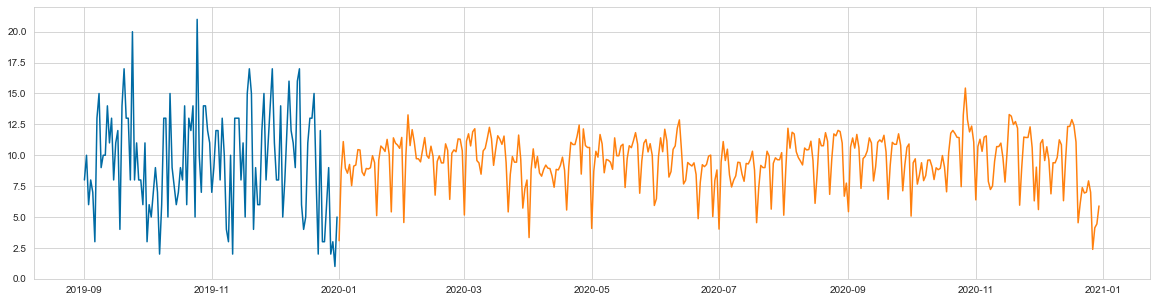

In [385]:
plt.figure(figsize=(20,5))
plt.plot(training_df['Cantidad_siniestros']['20190901':'20191231'])
plt.plot(test.xgb_Prediction)
plt.show()

In [239]:
test.to_excel('Prediction.xlsx')